## Use Use Multiple tools with LLM (ReAct) in Langgraph

In [14]:
from typing import TypedDict, Sequence, Annotated
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage
from langchain.agents import tool, initialize_agent
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI

load_dotenv()

True

### Create multiple tools, then create LLM and bind the tool to it.

In [15]:
@tool
def add(a:int, b:int):
    """This is an Addition function that adds two numbers together"""
    return a + b 

@tool
def subtract(a:int, b:int):
    """This is an Substration function that Substract one number from the other"""
    return a - b 

@tool
def multiply(a:int, b:int):
    """This is an Multiplication function that multiplies two numbers"""
    return a * b 



@tool
def divide(a:int, b:int):
    """This is an Division function that divides one numbers from the other"""
    return a / b 



tools = [add,subtract, multiply, divide]

#invoke llm and bind tools to it.
# model = ChatOpenAI(model="gpt-4o").bind_tools(tools)
model = ChatGoogleGenerativeAI(model='gemini-2.5-flash-preview-05-20').bind_tools(tools)

### Define the nodes

In [16]:
class AgentState(TypedDict):
    #this property uses add_meessage to concatenate messages passed to 'messages' instead of overwriting them
    messages: Annotated[Sequence[BaseMessage], add_messages]

def agent_call(state:AgentState)->AgentState:
    system_prompt = SystemMessage(content="You are my AI Assistant. Please answer my query to the best of your ability")

    response = model.invoke([system_prompt] + state['messages'])
    return {"messages":[response]}

def should_continue(state:AgentState):
    messages = state['messages']
    # check is there is a tool to call on the last message
    last_message = messages[-1]
    if last_message.tool_calls:
        return 'continue'
    else:
        return 'end'

### Connect the nodes and compile it

In [17]:
AGENT="Our Agent"
TOOL = "Tools"
graph= StateGraph(AgentState)

graph.add_node(AGENT, agent_call)

graph.add_edge(START, AGENT)

tool_node = ToolNode(tools=tools)
graph.add_node(TOOL, tool_node)

graph.add_conditional_edges(
    AGENT,
    should_continue,
    {
        "continue": TOOL,
        "end": END
    }
)

graph.add_edge(TOOL, AGENT)

app = graph.compile()

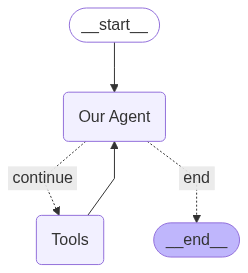

In [18]:
app

### Function to help with outputing the result

In [19]:
def print_stream(stream):
    for s in stream:
        message = s['messages'][-1]

        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [24]:
inputs = {"messages":[("Add 3 + 2 and multiply it by 10.")]}
# inputs = {"messages":[("user", "Add 3 + 4. Add 20 and 7 and write me a joke")]}
streams=app.stream(inputs,stream_mode="values")

In [25]:
for stream in streams:
    print(stream)
    print("="*50)
    print()

{'messages': [HumanMessage(content='Add 3 + 2 and multiply it by 10.', additional_kwargs={}, response_metadata={}, id='a16d091e-ac12-45b5-b131-1daecad712ce')]}

{'messages': [HumanMessage(content='Add 3 + 2 and multiply it by 10.', additional_kwargs={}, response_metadata={}, id='a16d091e-ac12-45b5-b131-1daecad712ce'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"a": 3.0, "b": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []}, id='run--b7dc6ddf-60d4-4df3-8de9-2fb84ccc0963-0', tool_calls=[{'name': 'add', 'args': {'a': 3.0, 'b': 2.0}, 'id': '0e625a0c-52b1-4180-aa51-5706bfa7fa83', 'type': 'tool_call'}], usage_metadata={'input_tokens': 240, 'output_tokens': 18, 'total_tokens': 334, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 76}})]}

{'messages': [HumanMessage(content='Ad

### Input the message and generate the output

In [26]:
inputs = {"messages":[("user", "Add 3 + 4. Add 20 and 7 and write me a joke")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 3 + 4. Add 20 and 7 and write me a joke
================================== Ai Message ==================================
Tool Calls:
  add (e4175dd3-eec0-459e-a359-ba5577dfe69b)
 Call ID: e4175dd3-eec0-459e-a359-ba5577dfe69b
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  add (0d99f1d1-1e4a-45ef-8de4-c66aa4683e95)
 Call ID: 0d99f1d1-1e4a-45ef-8de4-c66aa4683e95
  Args:
    a: 20.0
    b: 7.0
================================= Tool Message =================================
Name: add

27
================================== Ai Message ==================================

The sum of 3 and 4 is 7. The sum of 20 and 7 is 27.

Why don't scientists trust atoms?
Because they make up everything!


### Create anoter output to use multiple tools

In [18]:
inputs = {"messages":[("user", "Add 3 + 4 then multiply with my 10 then divide it by 2")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 3 + 4 then multiply with my 10 then divide it by 2
================================== Ai Message ==================================
Tool Calls:
  add (call_9TC1rSxd5CSArwtFoXvUXr3V)
 Call ID: call_9TC1rSxd5CSArwtFoXvUXr3V
  Args:
    a: 3
    b: 4
  multiply (call_6HNV2IZtz6NL63LlNkKix4HH)
 Call ID: call_6HNV2IZtz6NL63LlNkKix4HH
  Args:
    a: 7
    b: 10
================================= Tool Message =================================
Name: multiply

70
================================== Ai Message ==================================
Tool Calls:
  divide (call_jJ3DlZde67G6T4DwYzgov4aa)
 Call ID: call_jJ3DlZde67G6T4DwYzgov4aa
  Args:
    a: 70
    b: 2
================================= Tool Message =================================
Name: divide

35.0
================================== Ai Message ==================================

The result of adding 3 + 4, multiplying the result by 10, and then dividi